# Feature Engineering

## Importing the libraries

In [14]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif,SequentialFeatureSelector
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter



## Importing the dataset


In [15]:

data = pd.read_csv('../staging/data_set/master_dataset.csv')

## Feature Scaling

In [16]:
from sklearn.preprocessing import LabelEncoder

data = pd.get_dummies(data, columns=['crm_industry_current'])
data.columns = data.columns.str.replace(' ', '_')
data.drop(columns=['crm_industry_current'], errors='ignore', inplace=True)

le = LabelEncoder()
data['crm_employee_range'] = le.fit_transform(data['crm_employee_range'])




## Feature Creation

In [17]:
data['arr_change'] = data['future_arr'] - data['current_arr']
data['perc_change'] = (data['future_arr'] - data['current_arr']) / data['current_arr']
data['churn_flag'] = (data['future_arr'] < data['current_arr'] * 0.8).astype(int)

## Feature Grouping

In [18]:
data['seat_utilization_change'] = data['seat_utilization'] - data['seat_utilization_M_before']
data['max_seats_change'] = data['max_seats'] - data['max_seats_M_before']
data = data.drop(columns=['seat_utilization','seat_utilization_M_before','max_seats','max_seats_M_before'])

In [19]:
X1 = data.drop(columns=[
    'id', 'score_date', 'perc_change', 
    'total_pool_max_agents', 'crm_success_owner_change', 
    'legacy_flag','year_week','crm_industry_current_0', 'current_arr', "product_change_arr", "seat_change_arr",
       'future_arr', 'has_high_sev_outage',
    'discount_arr_usd_percentage', 'product_counts_percentage','crm_industry_current_Consumer_Services',
       'crm_industry_current_Corporate_Services',
       'crm_industry_current_Education',
       'crm_industry_current_Energy_&_Utilities',
       'crm_industry_current_Financial_Services',
       'crm_industry_current_Government', 'crm_industry_current_Healthcare',
       'crm_industry_current_Manufacturing_&_Resources',
       'crm_industry_current_Media_&_Entertainment',
       'crm_industry_current_Non-Profits_&_Associations',
       'crm_industry_current_Retail,_Wholesale_&_Distribution','crm_industry_current_Telecommunications','tickets_per_agent',
       'crm_industry_current_Transportation',
       'crm_industry_current_Travel_&_Hospitality', 'seat_utilization_change','crm_industry_current_Technology',
    'discount_arr_usd',
    
], errors='ignore')

In [20]:
y = X1['churn_flag']
X = X1.drop(columns=['churn_flag']) 

data = pd.DataFrame(X1)
print(data)


       segment_smb  segment_non_smb  segment_commercial  segment_enterprise  \
0              0.0              1.0                 0.0                 0.0   
1              0.0              1.0                 0.0                 0.0   
2              0.0              1.0                 0.0                 0.0   
3              0.0              1.0                 0.0                 0.0   
4              0.0              1.0                 0.0                 0.0   
...            ...              ...                 ...                 ...   
13412          0.0              1.0                 0.0                 0.0   
13413          0.0              1.0                 0.0                 0.0   
13414          0.0              1.0                 0.0                 0.0   
13415          0.0              1.0                 0.0                 0.0   
13416          0.0              1.0                 0.0                 0.0   

       segment_midmarket  region_emea  region_apac 

## Feature Correlation with Target Variable

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = data.select_dtypes(include=["number"])

corr_matrix = numeric_df.corr()

churn_corr = corr_matrix["churn_flag"].sort_values(ascending=False)
print("Top correlations with churn_flag:\n")
print(churn_corr)

Top correlations with churn_flag:

churn_flag                             1.000000
sales_assisted                         0.120638
pro_plus                               0.102230
seat_utilization_decrease              0.079100
is_provisioned_any_channel_M_before    0.076172
csat_score                             0.075655
ent_plus                               0.074756
billing_dunning_not_ok                 0.073168
team_plus                              0.073004
agent_utilization_decrease             0.072415
outreach_call_90dayflag                0.064874
region_latam                           0.056843
seat_utilization_increase              0.044821
crm_employee_range                     0.043245
fx_impact                              0.041472
num_low_sev_outages                    0.041194
segment_enterprise                     0.040733
agent_utilization_increase             0.033881
max_tickets_per_agent                  0.029382
segment_commercial                     0.028314
csat_

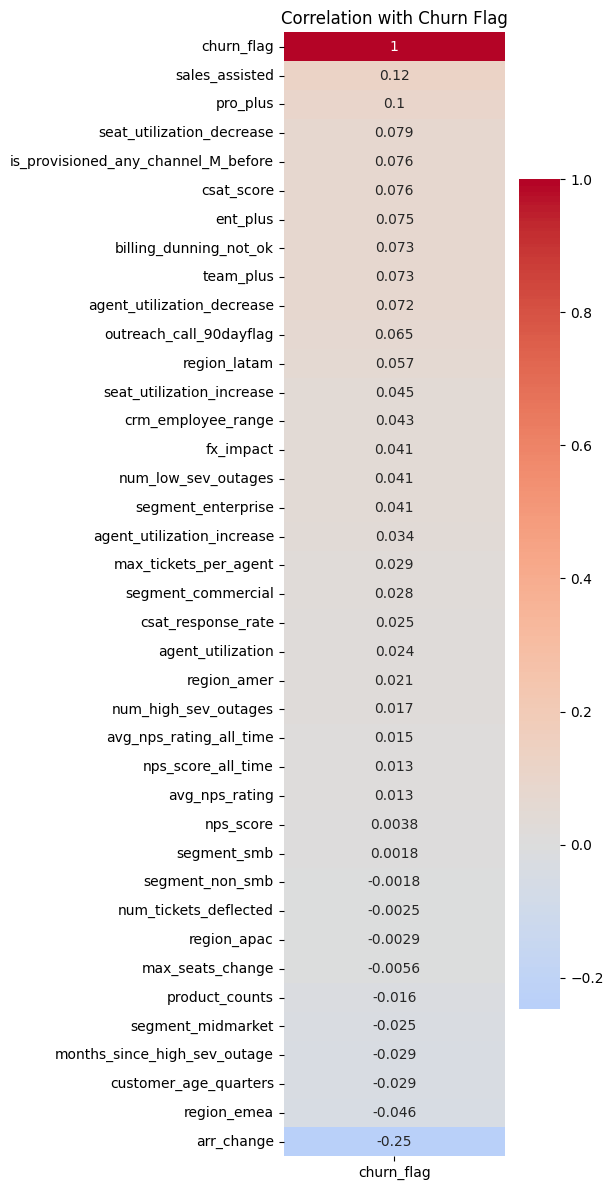

In [22]:
target_corr = corr_matrix[["churn_flag"]].sort_values(by="churn_flag", ascending=False)

plt.figure(figsize=(6, 12))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation with Churn Flag")
plt.tight_layout()
plt.show()

## Feature Selection

In [23]:
import pandas as pd

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

selected_features = selector.get_support(indices=True)

if isinstance(X, pd.DataFrame):
    feature_names = X.columns[selected_features]
    print("Selected Features:")
    print(feature_names)
else:
    print("Selected feature indices:")
    print(selected_features)

print("Transformed Feature Matrix:")
print(X_new)

Selected Features:
Index(['sales_assisted', 'billing_dunning_not_ok', 'arr_change', 'team_plus',
       'pro_plus', 'ent_plus', 'is_provisioned_any_channel_M_before',
       'agent_utilization_decrease', 'seat_utilization_decrease',
       'csat_score'],
      dtype='object')
Transformed Feature Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

ranking = selector.ranking_

if isinstance(X, pd.DataFrame):
    feature_names = X.columns
    selected_features = feature_names[selector.support_]
    print("Selected Features:")
    print(selected_features)

    feature_ranking = pd.DataFrame({'Feature': feature_names, 'Ranking': ranking})
    print("\nFeature Rankings:")
    print(feature_ranking.sort_values(by='Ranking'))
else:
    print("Feature rankings (indices):")
    print(ranking)






In [ ]:


sfs = SequentialFeatureSelector(estimator, n_features_to_select=25, direction='forward')
sfs.fit(X, y)

# Get the selected feature mask
selected_features_mask = sfs.get_support()

# If X is a DataFrame, get the feature names
if isinstance(X, pd.DataFrame):
    feature_names = X.columns.to_numpy()  # Ensure it's a NumPy array
    selected_features = feature_names[selected_features_mask]  # Selected features
    non_selected_features = feature_names[~selected_features_mask]  # Non-selected features

    print("Selected Features:")
    print(list(selected_features))

    print("\nNon-Selected Features:")
    print(list(non_selected_features))
else:
    print("Selected feature indices:")
    print([i for i, selected in enumerate(selected_features_mask) if selected])


## Feature Over Sampling

In [25]:
from imblearn.over_sampling import SMOTE
from collections import Counter



smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

X_resampled_df = pd.DataFrame(X_balanced, columns=X_balanced.columns)

X_resampled_df["churn_flag"] = y_balanced

X_resampled_df.to_csv("churn_features_selected.csv", index=False)

print("Balanced class distribution:", Counter(y_balanced))

Balanced class distribution: Counter({0: 12769, 1: 12769})
